In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [3]:
# Load the time series data from a CSV file
df = pd.read_csv('dataset/train_df.csv')
signals = pd.read_csv('dataset/gtrends_normalized.csv')

In [4]:
len(signals.index)

209

In [5]:
signals.head()

Unnamed: 0        date   sweater    Hoodie  Straw hat       Bra   T-shirt  \
0           0  2017-09-24  0.032727  0.076364   0.001636  0.098182  0.300000   
1           1  2017-10-01  0.038182  0.087273   0.001636  0.098182  0.289091   
2           2  2017-10-08  0.038182  0.087273   0.001636  0.109091  0.278182   
3           3  2017-10-15  0.043636  0.087273   0.001636  0.092727  0.261818   
4           4  2017-10-22  0.049091  0.087273   0.001636  0.092727  0.261818   

   Other accessories  Trousers  Underwear Tights  ...  Polo shirt  \
0            0.05625   0.24750           0.07125  ...    0.025714   
1            0.05625   0.26250           0.07500  ...    0.025714   
2            0.05625   0.24750           0.07125  ...    0.025714   
3            0.05625   0.25875           0.07500  ...    0.025714   
4            0.05625   0.25125           0.07125  ...    0.025714   

   Swimwear bottom      Ring       Tie  Necklace  Felt hat  Costumes  \
0             0.06  0.200000  0.058462  0.089231  0.153846  0.342857   
1             0.06  0.193846  0.055385  0.092308  0.156923  0.471429   
2             0.06  0.209231  0.058462  0.089231  0.163077  0.522857   
3             0.06  0.206154  0.055385  0.089231  0.175385  0.617143   
4             0.06  0.206154  0.058462  0.092308  0.184615  0.857143   

   Dungarees  Bodysuit  Kids Underwear top  
0   0.017143  0.025714            0.068571  
1   0.017143  0.025714            0.068571  
2   0.017143  0.025714            0.068571  
3   0.017143  0.017143            0.077143  
4   0.017143  0.025714            0.068571  

[5 rows x 109 columns]

In [7]:
df.iloc[:,3:6].head()

product_type_name graphical_appearance_name colour_group_name
0           Sweater                   Melange       Light Beige
1            Hoodie                   Melange      Light Orange
2            Hoodie                     Solid             Black
3         Straw hat                     Solid         Off White
4               Bra                     Solid       Light Beige

In [8]:
n = len(df.index) #700
pop = []
for i in range(n):
    sg = []
    for j in range(len(signals.index)):
        t = 0.0
        cat = df['product_type_name'].iloc[i]
        col = df['colour_group_name'].iloc[i]
        app = df['graphical_appearance_name'].iloc[i]
        if cat in signals.columns:
            t+=signals[cat].iloc[j]
        if col in signals.columns:
            t+=signals[col].iloc[j]
        if cat in signals.columns:
            t+=signals[cat].iloc[j]
        sg.append(t)
    pop.append(sg)

In [9]:
len(sg),len(pop)

(209, 700)

In [126]:
n = len(df.index) #700
train_data = []
test_data = []

train_len = int(len(df.iloc[0,9:-4])*0.8)
max_len =  len(df.iloc[0,9:-4])

for i in range(n):
    tr = df.iloc[i,9:-4].values.astype(float)[:train_len]
    te = df.iloc[i,9:-4].values.astype(float)[train_len:]
    train_data.append(torch.stack((torch.tensor(tr),torch.tensor(pop[i][:train_len]))))
    test_data.append(torch.stack((torch.tensor(te),torch.tensor(pop[i][train_len:max_len]))))

In [128]:
train_data = torch.stack(train_data,dim=0)
test_data = torch.stack(test_data,dim=0)
train_data.shape,test_data.shape

(torch.Size([700, 2, 84]), torch.Size([700, 2, 21]))

In [129]:
# Convert the time series data to PyTorch tensors
train_data = torch.tensor(train_data,dtype=float,device='cuda')
test_data = torch.tensor(test_data,dtype=float,device='cuda')

C:\Users\admim\AppData\Local\Temp\ipykernel_20848\2043313103.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = torch.tensor(train_data,dtype=float,device='cuda')
C:\Users\admim\AppData\Local\Temp\ipykernel_20848\2043313103.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = torch.tensor(test_data,dtype=float,device='cuda')


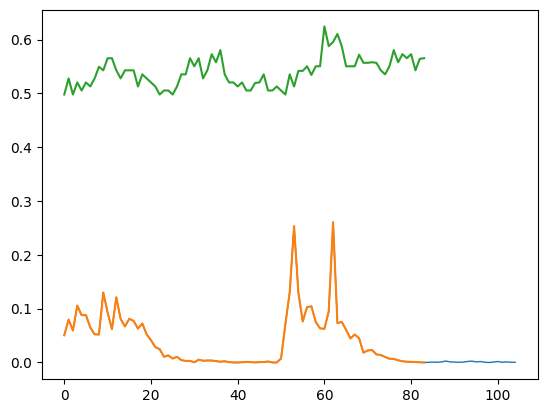

In [51]:
# z = 11
# plt.plot(train_data[z].tolist()+test_data[z].tolist(),label='Test',linewidth=1)
# plt.plot(train_data[z].tolist(),label='Train')
# plt.plot(pop[z][:train_data[z].shape[0]],label='gtrends')
# # plt.legend()
# plt.show()

In [272]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        # LSTM1
        self.lstm1 = nn.LSTM(input_size[1], hidden_size)
        self.fc1 = nn.Linear(hidden_size, output_size)
        # LSTM2
        self.lstm2 = nn.LSTM(input_size[1], hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        
        self.fc_cat = nn.Linear(2*output_size, output_size)        

    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.init_hidden(batch_size)
        
        lstm_out1, hidden1 = self.lstm1(input[0][0].unsqueeze(0).view(len(input), batch_size, -1).float().to('cpu'), hidden)
        output1 = self.fc1(lstm_out1[-1])
        
        lstm_out2, hidden2 = self.lstm2(input[0][1].unsqueeze(0).view(len(input), batch_size, -1).float().to('cpu'), hidden)
        output2 = self.fc2(lstm_out2[-1])
        
        cat = torch.cat([output1, output2],dim=1)
        output = self.fc_cat(cat)
        return output

    def init_hidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_size),
                torch.zeros(1, batch_size, self.hidden_size))

In [273]:
train_data.shape,test_data.shape

(torch.Size([700, 2, 84]), torch.Size([700, 2, 21]))

In [274]:
inputs[0][0].unsqueeze(0).view(len(inputs), 1, -1).shape

torch.Size([1, 1, 84])

In [266]:
test_data[i][0].shape

torch.Size([21])

In [277]:
# Define the hyperparameters
input_size = (train_data.shape[1],train_data.shape[2]) # (2,84)
hidden_size = 64
output_size = test_data.shape[2] #21
learning_rate = 3e-03
num_epochs = 20

train_loader = DataLoader(train_data)

# Instantiate the model
model = LSTM(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for i, inputs in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.to('cuda:0'), test_data[i][0].float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

Epoch [1/20], Step [100/700], Loss: 0.0002
Epoch [1/20], Step [200/700], Loss: 0.0000
Epoch [1/20], Step [300/700], Loss: 0.0000
Epoch [1/20], Step [400/700], Loss: 0.0001
Epoch [1/20], Step [500/700], Loss: 0.0001
Epoch [1/20], Step [600/700], Loss: 0.0000
Epoch [1/20], Step [700/700], Loss: 0.0000
Epoch [2/20], Step [100/700], Loss: 0.0001
Epoch [2/20], Step [200/700], Loss: 0.0000
Epoch [2/20], Step [300/700], Loss: 0.0000
Epoch [2/20], Step [400/700], Loss: 0.0001
Epoch [2/20], Step [500/700], Loss: 0.0002
Epoch [2/20], Step [600/700], Loss: 0.0000
Epoch [2/20], Step [700/700], Loss: 0.0000
Epoch [3/20], Step [100/700], Loss: 0.0001
Epoch [3/20], Step [200/700], Loss: 0.0000
Epoch [3/20], Step [300/700], Loss: 0.0000
Epoch [3/20], Step [400/700], Loss: 0.0001
Epoch [3/20], Step [500/700], Loss: 0.0002
Epoch [3/20], Step [600/700], Loss: 0.0000
Epoch [3/20], Step [700/700], Loss: 0.0000
Epoch [4/20], Step [100/700], Loss: 0.0001
Epoch [4/20], Step [200/700], Loss: 0.0000
Epoch [4/20

In [275]:
# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super().__init__()
#         self.hidden_size = hidden_size
#         self.lstm = nn.LSTM(input_size, hidden_size)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, input):
#         batch_size = input.size(0)
#         print('batch size: ',batch_size)
#         hidden = self.init_hidden(batch_size)
#         lstm_out, hidden = self.lstm(input.view(len(input), batch_size, -1).to('cuda:0'), hidden)
#         output = self.fc(lstm_out[-1])
#         return output

#     def init_hidden(self, batch_size):
#         return (torch.zeros(1, batch_size, self.hidden_size),
#                 torch.zeros(1, batch_size, self.hidden_size))

In [276]:
# # Define the hyperparameters
# input_size = len(train_data[0][0])
# hidden_size = 64
# output_size = len(test_data[0][0])
# learning_rate = 3e-03
# num_epochs = 20

# print(f'Input size: {input_size}')
# print(f'output size: {output_size}')

# train_loader = DataLoader(train_data)

# # Instantiate the model
# model = LSTM(input_size, hidden_size, output_size)

# # Define the loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Train the model
# for epoch in range(num_epochs):
#     for i, inputs in enumerate(train_loader):
#         optimizer.zero_grad()

#         # Forward pass
#         print(f'inputs: {inputs[0].shape}')
#         outputs = model(inputs[0][0].unsqueeze(0))
#         loss = criterion(outputs, test_data[i][0])

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#         if (i+1) % 100 == 0:
#             print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
#                   .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

In [42]:
train_data

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0007, 0.0015, 0.0011, 0.0007,
        0.0004, 0.0000, 0.0000, 0.0018, 0.0029, 0.0022, 0.0022, 0.0033, 0.0018, 0.0011, 0.0018, 0.0018, 0.0037, 0.0015, 0.0015, 0.0033, 0.0022, 0.0018, 0.0000, 0.0000, 0.0011, 0.0000, 0.0004, 0.0000,
        0.0004, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0015, 0.0004,
        0.0018, 0.0018, 0.0007, 0.0022, 0.0022, 0.0004, 0.0007, 0.0004, 0.0029, 0.0040, 0.0018, 0.0022])

In [279]:
val_df = pd.read_csv('dataset/train_df.csv')

In [280]:
# n = len(val_df.index) #700
# train_data = []
# test_data = []
# for i in range(n):
#     train_data.append(val_df.iloc[i,9:-4].values.astype(float)[:int(len(val_df.iloc[i,9:-4])*0.8)])
#     test_data.append(val_df.iloc[i,9:-4].values.astype(float)[int(len(val_df.iloc[i,9:-4])*0.8):])

# # Convert the time series data to PyTorch tensors
# train_data = torch.FloatTensor(train_data)
# test_data = torch.FloatTensor(test_data)

In [281]:
n = len(df.index) #700
train_data = []
test_data = []

train_len = int(len(df.iloc[0,9:-4])*0.8)
max_len =  len(df.iloc[0,9:-4])

for i in range(n):
    tr = df.iloc[i,9:-4].values.astype(float)[:train_len]
    te = df.iloc[i,9:-4].values.astype(float)[train_len:]
    train_data.append(torch.stack((torch.tensor(tr),torch.tensor(pop[i][:train_len]))))
    test_data.append(torch.stack((torch.tensor(te),torch.tensor(pop[i][train_len:max_len]))))
    
train_data = torch.stack(train_data,dim=0)
test_data = torch.stack(test_data,dim=0)
train_data.shape,test_data.shape

(torch.Size([700, 2, 84]), torch.Size([700, 2, 21]))

In [ ]:
train_data

In [287]:
# Set the model to evaluation mode
model.eval()
test_loader = DataLoader(train_data)

# Define the test loop
test_loss = 0.0
with torch.no_grad():
    for a in train_data:
        # Forward pass
        outputs = model(a.unsqueeze(0).to('cuda:0'))
        loss = criterion(outputs, test_data[i])
        test_loss += loss.item()
        

    # Compute the evaluation metrics
    avg_test_loss = test_loss / len(test_loader)
    print('Average Test Loss: {:.4f}'.format(avg_test_loss))

C:\Users\admim\anaconda3\envs\POP\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2, 21])) that is different to the input size (torch.Size([1, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.3450


In [84]:
# # Set the model to evaluation mode
# model.eval()
# test_loader = DataLoader(train_data)

# # Define the test loop
# test_loss = 0.0
# with torch.no_grad():
#     for a in test_loader:
#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, test_data[i])
#         test_loss += loss.item()

#     # Compute the evaluation metrics
#     avg_test_loss = test_loss / len(test_loader)
#     print('Average Test Loss: {:.4f}'.format(avg_test_loss))

Average Test Loss: 0.0001


C:\Users\admim\anaconda3\envs\POP\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([1, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [130]:
len(train_data[0]),len(test_data[0])

(84, 21)

In [138]:
pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')
import matplotlib

SMALL_SIZE = 8
matplotlib.rc('font', size=SMALL_SIZE)

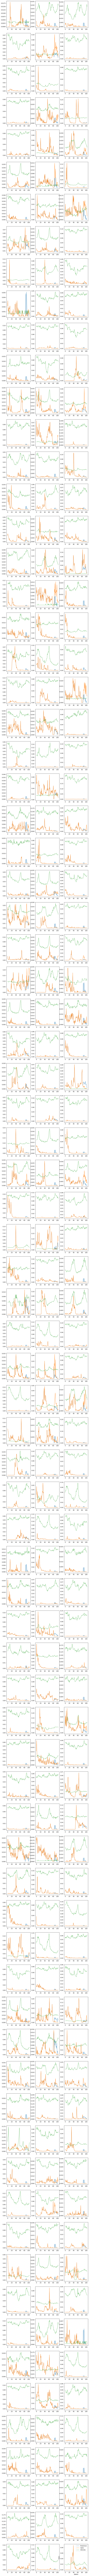

In [302]:
cols = 3
rows = 80
fig, ax = plt.subplots(ncols=cols,nrows=rows,figsize=(11,350))

idx=0
for i in range(rows):
    for j in range(cols):
        with torch.no_grad():
            outputs = model(train_data[idx].unsqueeze(0).to('cuda:0'))
        for ii in range(len(outputs[0])):
            if outputs[0][ii] < 0:
                outputs[0][ii] = 0
                
        trnds = (train_data[idx][1].tolist()+test_data[idx][1].tolist())
        for y in range(len(trnds)):
            trnds[y] = trnds[y]*0.1
        ax[i,j].plot(train_data[idx][0].tolist()+outputs[0].tolist(),label = "Prediction", linewidth=1)
        ax[i,j].plot(train_data[idx][0].tolist()+test_data[idx][0].tolist(),label = "Sales", linewidth=1.2)
        ax[i,j].plot(trnds,label = "Gtrends", linewidth=0.9)
        idx+=1

plt.xlabel('Weeks')
plt.ylabel('Sales')
plt.legend()
plt.show()